# Fine-Tuning of OpenAI detector

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Colab Notebooks/ai_text_detection/cookbooks

/content/drive/MyDrive/Colab Notebooks/ai_text_detection/cookbooks


In [1]:
import json
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
# import tqdm
from sklearn.utils import resample
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [2]:
import sys
import os
sys.path.append("/mnt/data/bobae/ai_text_detection")

from utils.cuda_helper import *

### Set GPU

In [3]:
print_gpu_usage()

Current GPU memory usage: 0.00 MB
Maximum GPU memory usage: 0.00 MB


In [4]:
print_gpu_devie_name()

cuda 0: NVIDIA GeForce RTX 2080 Ti
cuda 1: NVIDIA GeForce RTX 2080 Ti


In [20]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
num_gpus = torch.cuda.device_count()

if num_gpus>1:
    device = "cuda:0"

In [21]:
device

'cuda:0'

In [59]:
# Get the device properties for the current GPU
device_props = torch.cuda.get_device_properties(torch.cuda.current_device())
print(device_props)

# Print the total GPU memory in gigabytes
total_gpu_memory = device_props.total_memory / (1024**3)
print(f"Total GPU memory: {total_gpu_memory:.2f} GB")

_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)
Total GPU memory: 10.75 GB


### Load json data file and convert to dataframe

In [2]:
# human data

# loads a tofel dataset
with open('../dataset/human/tofel.json', "r") as f:
    h_tofel_dataset = json.load(f)

# loads an arxiv dataset
with open('../dataset/human/arxiv.json', "r") as f:
    h_arxiv_dataset = json.load(f)

# loads student essay
with open('../dataset/human/student_essay.json', "r") as f:
    h_essay_dataset = json.load(f)

# loads student computer essay
with open('../dataset/human/student_cs_essay.json', "r") as f:
    h_essay_cs_dataset = json.load(f)

In [3]:
# gpt data

# loads a tofel dataset
with open('../dataset/ai/gpt2medium_tofel.json', "r") as f:
    gpt_tofel_dataset = json.load(f)

# loads an arxiv dataset
with open('../dataset/ai/gpt2medium_arxiv.json', "r") as f:
    gpt_arxiv_dataset = json.load(f)

# loads student essay
with open('../dataset/ai/gpt2medium_essay.json', "r") as f:
    gpt_essay_dataset = json.load(f)

# loads student computer essay
with open('../dataset/ai/gpt2medium_essay_cs.json', "r") as f:
    gpt_essay_cs_dataset = json.load(f)

# loads a tofel dataset
with open('../dataset/ai/gpt35_tofel.json', "r") as f:
    gpt_35_tofel_dataset = json.load(f)

# loads student computer essay
with open('../dataset/ai/gpt35_essay_cs.json', "r") as f:
    gpt_35_essay_cs_dataset = json.load(f)

In [4]:
h_dataset = []
for i in [h_tofel_dataset, h_arxiv_dataset, h_essay_dataset, h_essay_cs_dataset]:
    h_dataset.extend(i)

len(h_dataset)

2478

In [5]:
gpt_dataset = []
for i in [gpt_tofel_dataset, gpt_arxiv_dataset, gpt_essay_dataset, gpt_essay_cs_dataset,
          gpt_35_tofel_dataset, gpt_35_essay_cs_dataset]:
    gpt_dataset.extend(i)

len(gpt_dataset)

2956

In [6]:
dct = {
    "text": [item['input'] for item in h_dataset] + [item['input'] for item in gpt_dataset],
    "label": [item['label'] for item in h_dataset] + [item['label'] for item in gpt_dataset],
}

df = pd.DataFrame(dct)

def label_to_numeric(value):
    if value == "human":
        return 1
    else:
        return 0

df['target'] = df['label'].apply(lambda x: label_to_numeric(x))

In [8]:
class_counts = df['target'].value_counts()
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

# Separate majority and minority classes
majority_df = df[df['target'] == majority_class]
minority_df = df[df['target'] == minority_class]

# Undersample majority class
undersampled_majority_df = resample(majority_df,
                                    replace=False,  # Sample without replacement
                                    n_samples=len(minority_df),  # Match minority class size
                                    random_state=42)  # For reproducibility

# Combine minority class with undersampled majority class
undersampled_df = pd.concat([undersampled_majority_df, minority_df])
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
df = undersampled_df
df

,text,label,target
0,Analysis of Smartex Clothing Ltd. Company Essa...,human,1
1,"I read a lot in my spare time, and the book I ...",human,1
2,We show that there is an hierarchy of intersec...,human,1
3,Yang's theorem forbids the process $Z^0 \to 2\...,human,1
4,Gender Stereotypes and Sexual Discrimination E...,human,1
...,...,...,...
4951,The answer would be TV. I grew up in a very sm...,human,1
4952,Computer Technician and Labor Market Essay\n\n...,human,1
4953,A complete set of polarization transfer observ...,human,1
4954,Role and Impact of Gospel in Healthcare Essay\...,human,1


### Preparing the Dataset and Dataloader

In [9]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = self.data.text
        self.target = self.data.target
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            pad_to_max_length=True,
            max_length=self.max_len,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(self.target[index], dtype=torch.float)
        }

In [10]:
tokenizer = AutoTokenizer.from_pretrained("TrustSafeAI/RADAR-Vicuna-7B")
model = AutoModelForSequenceClassification.from_pretrained("TrustSafeAI/RADAR-Vicuna-7B")

/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [11]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 1
LEARNING_RATE = 1e-05
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [12]:
train_size = 0.8
train_data=df.sample(frac=train_size, random_state=42)
test_data=df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (4956, 3)
TRAIN Dataset: (3965, 3)
TEST Dataset: (991, 3)


In [13]:
train_params = {'batch_size': TRAIN_BATCH_SIZE, 'shuffle': True, 'num_workers': 0}
test_params = {'batch_size': VALID_BATCH_SIZE, 'shuffle': True, 'num_workers': 0}

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

### Fine Tuning Functions

In [14]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [15]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [54]:
# Training Loop with Early Stopping:**
def train_model(epochs, file_name, model):
  best_loss = float('inf')
  best_model_weights = None
  patience = 10

  train_losses = []
  valid_losses = []

  model = model.to(device)
  for epoch in range(1, epochs+1):
    n_correct = 0
    tr_loss = 0
    nb_tr_steps = 0; nb_tr_examples = 0;

    ###################
    # train the model #
    ###################
    model.train()
    for i, data in enumerate(tqdm(training_loader)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss_ = loss_function(outputs.logits, targets)

        tr_loss += loss_.item()
        big_val, big_idx = torch.max(outputs.logits, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if i%100==0:
            step_loss = tr_loss/nb_tr_steps
            step_acc = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 100 steps: {step_loss}")
            print(f"Training Accuracy per 100 steps: {step_acc}")
            print("=="*50)

        optimizer.zero_grad()
        loss_.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    train_epoch_loss = tr_loss/nb_tr_steps
    train_epoch_acc = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {train_epoch_loss}")
    print(f"Training Accuracy Epoch: {train_epoch_acc}")
    train_losses.append(train_epoch_loss)

    # ######################
    # # validate the model #
    # ######################
    # model.eval()  # Set model to evaluation mode
    # val_n_correct = 0; val_n_wrong = 0; total = 0;
    # val_loss = 0;
    # nb_val_steps = 0; nb_val_example = 0;
    # with torch.no_grad():  # Disable gradient calculation for validation
    #     for i, data in enumerate(tqdm(testing_loader)):
    #       ids = data['ids'].to(device, dtype = torch.long)
    #       mask = data['mask'].to(device, dtype = torch.long)
    #       token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
    #       targets = data['target'].to(device, dtype = torch.long)

    #       outputs = model(ids, mask, token_type_ids)
    #       loss_ = loss_function(outputs.logits, targets)

    #       val_loss += loss_.item()
    #       big_val, big_idx = torch.max(outputs.logits, dim=1)
    #       val_n_correct += calcuate_accuracy(big_idx, targets)

    #       nb_val_steps += 1
    #       nb_val_examples += targets.size(0)

    #       if i%100==0:
    #         step_loss = tr_loss/nb_tr_steps
    #         step_acc = (n_correct*100)/nb_tr_examples
    #         print(f"Validation Loss per 100 steps: {step_loss}")
    #         print(f"Validation Accuracy per 100 steps: {step_acc}")

    #       if val_loss < best_loss:
    #         best_loss = val_loss
    #         best_model_weights = copy.deepcopy(model.state_dict())
    #         patience = 10  # Reset patience counter
    #       else:
    #         patient -= 1
    #         if patient == 0:
    #           print("="*50)
    #           print("="*20, "early stop", "="*20)
    #           print("="*50)
    #           break

    # valid_epoch_loss = val_loss/nb_val_steps
    # valid_epoch_accu = (val_n_correct*100)/nb_val_example
    # print(f"Validation Loss Epoch: {valid_epoch_loss}")
    # print(f"Validation Accuracy Epoch: {valid_epoch_accu}")
    # valid_losses.append(valid_epoch_loss)


    path = '/content/drive/MyDrive/Colab Notebooks/ai_text_detection/models/'+file_name+'_epoch'+str(epoch)+'.pth'
    torch.save(model.state_dict(), path)

  return train_losses, valid_losses

In [16]:
# train_losses, valid_losses = train_model(4, str('23May2024_2'), model)

In [17]:
# train_losses, valid_losses

In [18]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
def train(epoch, model, device):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model = model.to(device)
    model.train()

    # for i, data in tqdm(enumerate(training_loader, 0), total=len(training_loader)):
    # for _, data in tqdm(enumerate(training_loader, 0)):
    for i, data in enumerate(tqdm(training_loader)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs.logits, targets)

        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.logits, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if i%100==0:
            step_loss = tr_loss/nb_tr_steps
            step_acc = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 100 steps: {step_loss}")
            print(f"Training Accuracy per 100 steps: {step_acc}")
            print("=="*50)

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_acc = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_acc}")

    return epoch_loss, epoch_acc, step_loss, step_acc

### Fine Tuning without checking validation error

In [95]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [22]:
EPOCHS = 5

train_result = []
for epoch in range(EPOCHS):
    train_result.append(train(epoch, model, device))

    # with gpt paraphrased data, epoch=10
    file_name = "".join('../models/radar_finetune_models/20240528_v1_epoch'+str(epoch)+'.pth')
    torch.save(model, file_name)

  0%|                                                                                         | 0/496 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of 

Training Loss per 100 steps: 0.11431130021810532
Training Accuracy per 100 steps: 100.0


 20%|████████████████                                                               | 101/496 [00:39<02:34,  2.55it/s]

Training Loss per 100 steps: 0.0015314909520240312
Training Accuracy per 100 steps: 100.0


 41%|████████████████████████████████                                               | 201/496 [01:19<01:55,  2.56it/s]

Training Loss per 100 steps: 0.0007910566971045386
Training Accuracy per 100 steps: 100.0


 61%|███████████████████████████████████████████████▉                               | 301/496 [01:58<01:16,  2.55it/s]

Training Loss per 100 steps: 0.0005357770966999014
Training Accuracy per 100 steps: 100.0


 81%|███████████████████████████████████████████████████████████████▊               | 401/496 [02:37<00:37,  2.55it/s]

Training Loss per 100 steps: 0.0004062697225822546
Training Accuracy per 100 steps: 100.0


100%|███████████████████████████████████████████████████████████████████████████████| 496/496 [03:14<00:00,  2.55it/s]


The Total Accuracy for Epoch 0: 100.0
Training Loss Epoch: 0.00033067218828731007
Training Accuracy Epoch: 100.0


  0%|▏                                                                                | 1/496 [00:00<01:37,  5.07it/s]

Training Loss per 100 steps: 1.0922477486019488e-05
Training Accuracy per 100 steps: 100.0


 20%|████████████████                                                               | 101/496 [00:39<02:35,  2.54it/s]

Training Loss per 100 steps: 9.413488442078233e-06
Training Accuracy per 100 steps: 100.0


 41%|████████████████████████████████                                               | 201/496 [01:18<01:56,  2.54it/s]

Training Loss per 100 steps: 8.462103337410894e-06
Training Accuracy per 100 steps: 100.0


 61%|███████████████████████████████████████████████▉                               | 301/496 [01:58<01:16,  2.54it/s]

Training Loss per 100 steps: 7.697024928927816e-06
Training Accuracy per 100 steps: 100.0


 81%|███████████████████████████████████████████████████████████████▊               | 401/496 [02:37<00:37,  2.54it/s]

Training Loss per 100 steps: 7.5577628277662775e-06
Training Accuracy per 100 steps: 100.0


100%|███████████████████████████████████████████████████████████████████████████████| 496/496 [03:14<00:00,  2.54it/s]


The Total Accuracy for Epoch 1: 100.0
Training Loss Epoch: 6.944964667354725e-06
Training Accuracy Epoch: 100.0


  0%|▏                                                                                | 1/496 [00:00<01:41,  4.87it/s]

Training Loss per 100 steps: 4.053107204526896e-06
Training Accuracy per 100 steps: 100.0


 20%|████████████████                                                               | 101/496 [00:39<02:35,  2.54it/s]

Training Loss per 100 steps: 5.302932739069358e-06
Training Accuracy per 100 steps: 100.0


 41%|████████████████████████████████                                               | 201/496 [01:18<01:56,  2.54it/s]

Training Loss per 100 steps: 4.385329224424456e-06
Training Accuracy per 100 steps: 100.0


 61%|███████████████████████████████████████████████▉                               | 301/496 [01:58<01:16,  2.54it/s]

Training Loss per 100 steps: 3.912923753990032e-06
Training Accuracy per 100 steps: 100.0


 81%|███████████████████████████████████████████████████████████████▊               | 401/496 [02:37<00:37,  2.54it/s]

Training Loss per 100 steps: 3.6088726141601196e-06
Training Accuracy per 100 steps: 100.0


100%|███████████████████████████████████████████████████████████████████████████████| 496/496 [03:15<00:00,  2.54it/s]


The Total Accuracy for Epoch 2: 100.0
Training Loss Epoch: 3.3927150300333018e-06
Training Accuracy Epoch: 100.0


  0%|▏                                                                                | 1/496 [00:00<01:38,  5.05it/s]

Training Loss per 100 steps: 2.1159626157896128e-06
Training Accuracy per 100 steps: 100.0


 20%|████████████████                                                               | 101/496 [00:39<02:35,  2.54it/s]

Training Loss per 100 steps: 2.2540551472588103e-06
Training Accuracy per 100 steps: 100.0


 41%|████████████████████████████████                                               | 201/496 [01:18<01:56,  2.54it/s]

Training Loss per 100 steps: 2.1435400743197606e-06
Training Accuracy per 100 steps: 100.0


 61%|███████████████████████████████████████████████▉                               | 301/496 [01:58<01:16,  2.54it/s]

Training Loss per 100 steps: 2.0292285413789884e-06
Training Accuracy per 100 steps: 100.0


 81%|███████████████████████████████████████████████████████████████▊               | 401/496 [02:37<00:37,  2.54it/s]

Training Loss per 100 steps: 1.936145228134145e-06
Training Accuracy per 100 steps: 100.0


100%|███████████████████████████████████████████████████████████████████████████████| 496/496 [03:14<00:00,  2.54it/s]


The Total Accuracy for Epoch 3: 100.0
Training Loss Epoch: 1.8617716776706432e-06
Training Accuracy Epoch: 100.0


  0%|▏                                                                                | 1/496 [00:00<01:40,  4.93it/s]

Training Loss per 100 steps: 1.7136318319899146e-06
Training Accuracy per 100 steps: 100.0


 20%|████████████████                                                               | 101/496 [00:39<02:35,  2.54it/s]

Training Loss per 100 steps: 1.4071995675555745e-06
Training Accuracy per 100 steps: 100.0


 41%|████████████████████████████████                                               | 201/496 [01:18<01:56,  2.54it/s]

Training Loss per 100 steps: 1.3667541663914622e-06
Training Accuracy per 100 steps: 100.0


 61%|███████████████████████████████████████████████▉                               | 301/496 [01:58<01:16,  2.54it/s]

Training Loss per 100 steps: 1.3170933209985258e-06
Training Accuracy per 100 steps: 100.0


 81%|███████████████████████████████████████████████████████████████▊               | 401/496 [02:37<00:37,  2.54it/s]

Training Loss per 100 steps: 1.2781916696762087e-06
Training Accuracy per 100 steps: 100.0


100%|███████████████████████████████████████████████████████████████████████████████| 496/496 [03:15<00:00,  2.54it/s]


The Total Accuracy for Epoch 4: 100.0
Training Loss Epoch: 1.2457902467041726e-06
Training Accuracy Epoch: 100.0


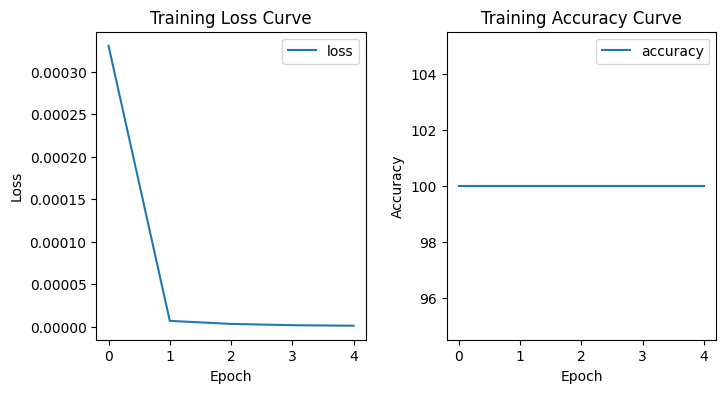

In [23]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot the loss curve on the first subplot
ax1.plot(range(len(train_result)), [item[0] for item in train_result], label="loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Curve')
ax1.legend()

# Plot another metric on the second subplot
# Replace the following line with your desired plot
ax2.plot(range(len(train_result)), [item[1] for item in train_result], label="accuracy")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy Curve')
ax2.legend()

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()

In [24]:
# test
!python ../models/openai_finetune_detector.py --model_name "20240528_v1_epoch4.pth" --text "My name is bobae bak" 
    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Traceback (most recent call last):
  File "/mnt/data/bobae/ai_text_detection/cookbooks/../models/openai_finetune_detector.py", line 59, in <module>
    model = torch.load("".join(PARENT_DIR+"/models/openai_finetune_models/"+args.model_name), map_location=torch.device('cpu'))
  File "/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/torch/serialization.py", line 997, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/torch/serialization.py", line 444, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/torch/serialization.py", line 425, in __init__
    super().__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/bobae/ai_text_detection/models/openai_finetune_models/20240528_v1_epoch4.pth'


### Validate

In [90]:
def valid(model, testing_loader):
    model = model.to(device)
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        # for _, data in tqdm(enumerate(testing_loader, 0)):
        for i, data in enumerate(iter(testing_loader)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['target'].to(device, dtype = torch.long)

            outputs = model(ids, mask, token_type_ids)
            loss = loss_function(outputs.logits, targets)

            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.logits, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if i%100==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_loss, epoch_accu

In [91]:
# model_1 validation
model_1 = torch.load('../models/openai_finetune_models/20240523_v1_epoch0.pth')
val_epoch_loss, val_epoch_acc = valid(model_1, testing_loader)
print(val_epoch_loss, val_epoch_acc)

/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Validation Loss per 100 steps: 0.14860263466835022
Validation Accuracy per 100 steps: 100.0
Validation Loss per 100 steps: 0.08055920187167197
Validation Accuracy per 100 steps: 96.65841584158416
Validation Loss Epoch: 0.08093919815409238
Validation Accuracy Epoch: 96.56912209889
0.08093919815409238 96.56912209889


In [94]:
# model_4 validation

model_4 = torch.load('../models/openai_finetune_models/20240523_v1_epoch4.pth')
val_epoch_loss, val_epoch_acc = valid(model_4, testing_loader)
print(val_epoch_loss, val_epoch_acc)

Validation Loss per 100 steps: 0.4960307776927948
Validation Accuracy per 100 steps: 87.5
Validation Loss per 100 steps: 0.07441227190342897
Validation Accuracy per 100 steps: 98.26732673267327
Validation Loss Epoch: 0.066691413367798
Validation Accuracy Epoch: 98.38546922300706
0.066691413367798 98.38546922300706


In [ ]:
# output_model_file = 'pytorch_roberta_sentiment.bin'
# output_vocab_file = './'

# model_to_save = model
# torch.save(model_to_save, output_model_file)
# tokenizer.save_vocabulary(output_vocab_file)

# print('All files saved')
# print('This tutorial is completed')

In [96]:
model_1 = None
model_4 = None